# Fit using linear and paw law

In [1]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\Varios_vecinos\\venv\\src')

In [2]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
import style
from ising.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

In C:\Users\MHJGuillermo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\MHJGuillermo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\MHJGuillermo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\MHJGuillermo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotli

Populating the interactive namespace from numpy and matplotlib


## Model
El modelo a utilizar es:
$$ \frac{1}{T} = a_1 + a_2 \frac{1}{n_v} + a3 \left(\frac{1}{n_v}\right)^{a_4} $$ 

In [32]:
# def model_function(x: float,a1: float,a2: float,a3: float,a4: float):
#     return a1 + a2*(x) + a3*(x)**a4

def model_function(x: float,a1: float,a3: float,a4: float):
    return a1 + a3*(x)**a4

In [33]:
# def get_extrapol_function(model_function,a1,a2,a3,a4):
#     def extrapol_funct(x):
#         return model_function(x,a1,a2,a3,a4)
#     return extrapol_funct

def get_extrapol_function(model_function,a1,a3,a4):
    def extrapol_funct(x):
        return model_function(x,a1,a3,a4)
    return extrapol_funct

## Read files

In [26]:
data_path = Path("../../data/regular/infinite-size").resolve()
file = 'regular_all_inv_Tc.csv'
df_all_tc = pd.read_csv(os.path.join(data_path,file))

In [27]:
df_all_tc

,1/nv,P1.0,P1.05,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
0,0.500000,0.662721,0.671622,0.680297,0.700150,0.717028,0.734866,0.751727,0.770168,0.786703,0.803441,0.820681,0.835529
1,0.333333,0.505386,0.516743,0.528284,0.546419,0.574539,0.597153,0.619581,0.642793,0.665299,0.687169,0.709461,0.732735
2,0.250000,0.425707,0.438057,0.450768,0.472832,0.501265,0.528284,0.555318,0.580268,0.606328,0.631346,0.656782,0.680642
3,0.200000,0.375812,0.389057,0.402337,0.429970,0.456688,0.485307,0.512765,0.541671,0.569954,0.598822,0.626314,0.653388
4,0.166667,0.341083,0.354681,0.368523,0.396765,0.424721,0.455167,0.486573,0.515543,0.545704,0.574864,0.605612,0.634517
5,0.142857,0.315105,0.328996,0.343136,0.372431,0.401683,0.432891,0.463020,0.495621,0.527741,0.560164,0.590963,0.622788
6,0.125000,0.294999,0.308949,0.323355,0.353053,0.383836,0.415381,0.447872,0.480460,0.513612,0.546888,0.579394,0.611867
7,0.111111,0.278617,0.292798,0.307334,0.337482,0.368796,0.401333,0.434561,0.468367,0.502578,0.536848,0.570911,0.604637
8,0.100000,0.265052,0.279327,0.293982,0.324509,0.356434,0.389497,0.423546,0.458147,0.493491,0.528531,0.563834,0.598451
9,0.090909,0.253624,0.267970,0.282715,0.313452,0.345748,0.379390,0.414121,0.449594,0.485589,0.521795,0.558070,0.593677


In [44]:
df_params = pd.DataFrame(index=["a1","a3","a4"])
df_extrapol_val = pd.DataFrame(index=["infty","1"])

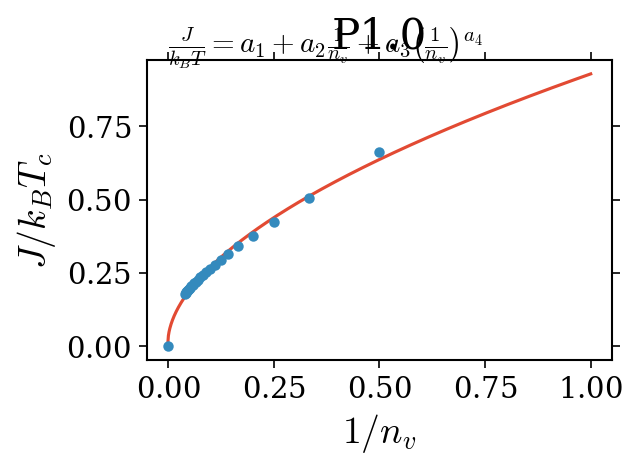

a1: 0.016979404186474555
a3: 0.912126057739348
a4: 0.5564732884991481
Extrapolation:
0.016979404186474555 at 1/nv=0
0.9291054619258226 at 1/nv=1
min:0.016979404186474555 at 0.0




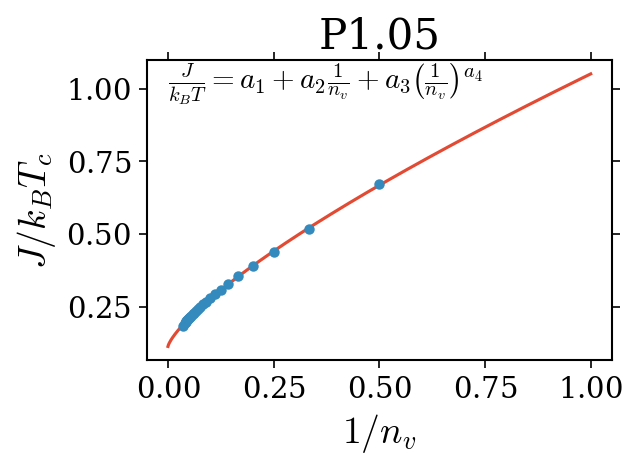

a1: 0.11403428699688542
a3: 0.9368143418038796
a4: 0.7580307084005722
Extrapolation:
0.11403428699688542 at 1/nv=0
1.050848628800765 at 1/nv=1
min:0.11403428699688542 at 0.0




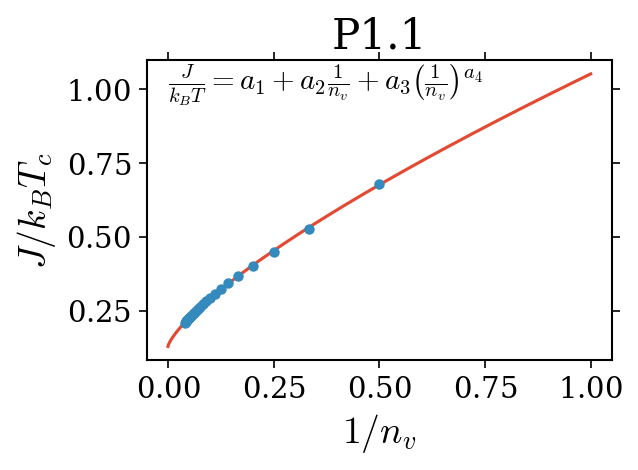

a1: 0.12963754817784973
a3: 0.9230998259490085
a4: 0.7542375128770267
Extrapolation:
0.12963754817784973 at 1/nv=0
1.0527373741268582 at 1/nv=1
min:0.12963754817784973 at 0.0




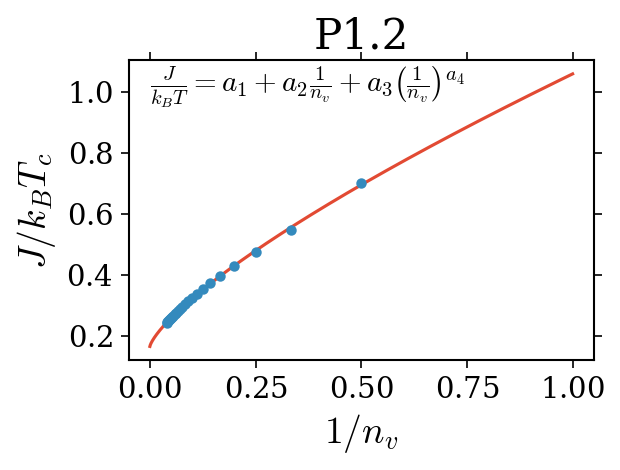

a1: 0.1648663543832774
a3: 0.8934691780702216
a4: 0.7546225499993504
Extrapolation:
0.1648663543832774 at 1/nv=0
1.058335532453499 at 1/nv=1
min:0.1648663543832774 at 0.0




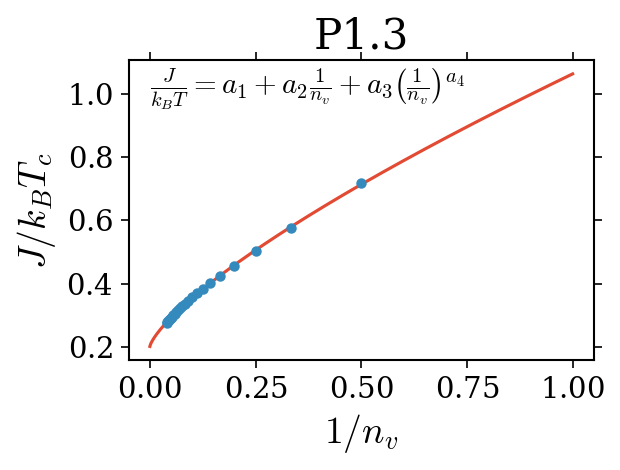

a1: 0.20106425772687217
a3: 0.8617989047189034
a4: 0.7506201028085436
Extrapolation:
0.20106425772687217 at 1/nv=0
1.0628631624457756 at 1/nv=1
min:0.20106425772687217 at 0.0




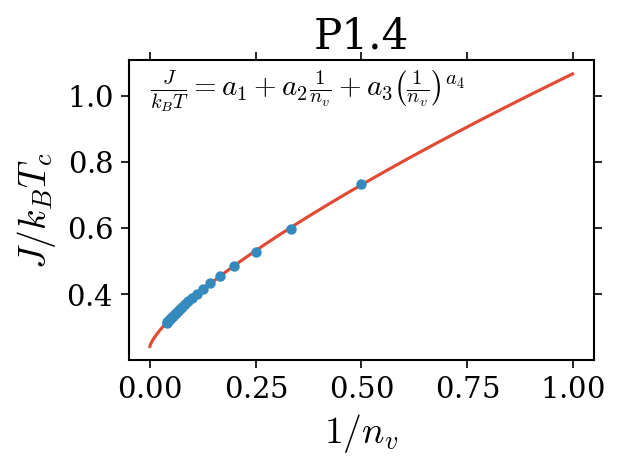

a1: 0.24238238563466113
a3: 0.8246523401658108
a4: 0.755024007292976
Extrapolation:
0.24238238563466113 at 1/nv=0
1.067034725800472 at 1/nv=1
min:0.24238238563466113 at 0.0




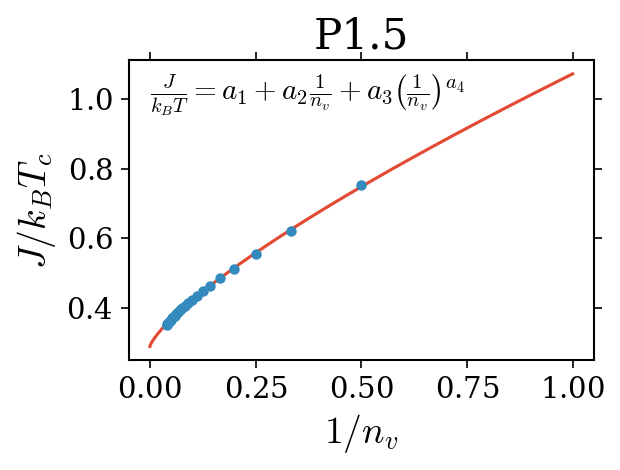

a1: 0.288786052404071
a3: 0.784025561873916
a4: 0.7714736084243489
Extrapolation:
0.288786052404071 at 1/nv=0
1.072811614277987 at 1/nv=1
min:0.288786052404071 at 0.0




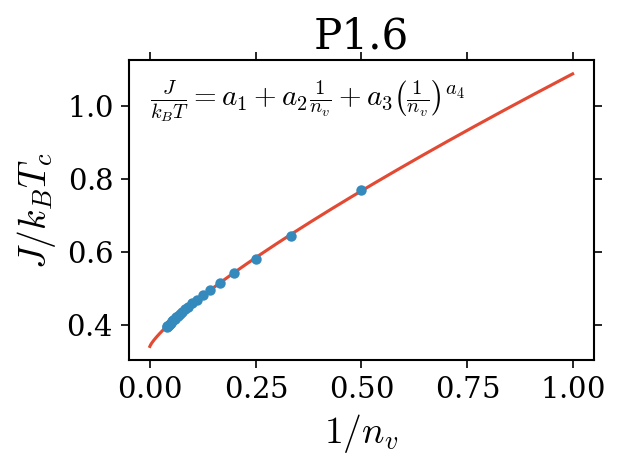

a1: 0.34043264579702326
a3: 0.7474120957602859
a4: 0.8100227027562299
Extrapolation:
0.34043264579702326 at 1/nv=0
1.0878447415573091 at 1/nv=1
min:0.34043264579702326 at 0.0




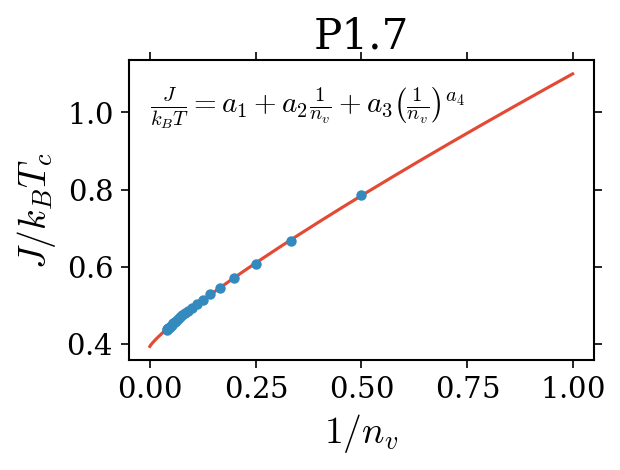

a1: 0.3929649079303452
a3: 0.706955662529289
a4: 0.8550099600170986
Extrapolation:
0.3929649079303452 at 1/nv=0
1.0999205704596342 at 1/nv=1
min:0.3929649079303452 at 0.0




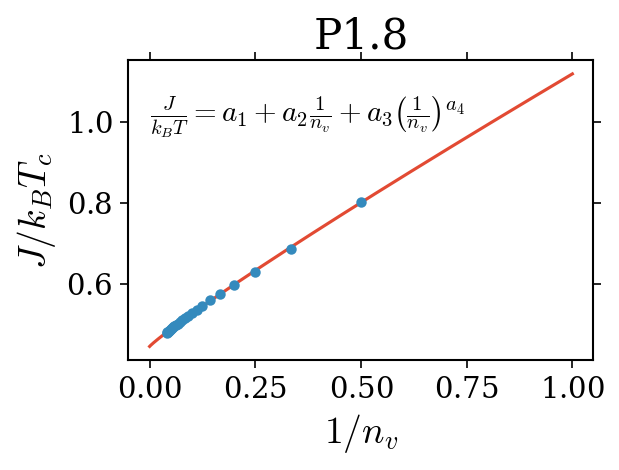

a1: 0.4469962799279196
a3: 0.6707410505317943
a4: 0.9216692157529102
Extrapolation:
0.4469962799279196 at 1/nv=0
1.117737330459714 at 1/nv=1
min:0.4469962799279196 at 0.0




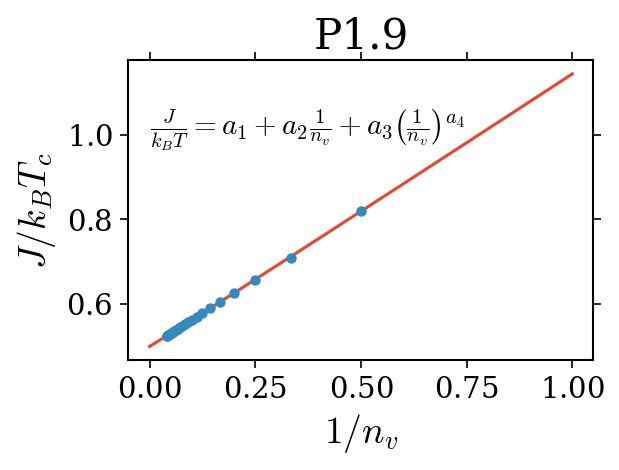

a1: 0.5004355760710506
a3: 0.6428745481494178
a4: 1.0121171200191763
Extrapolation:
0.5004355760710506 at 1/nv=0
1.1433101242204684 at 1/nv=1
min:0.5004355760710506 at 0.0




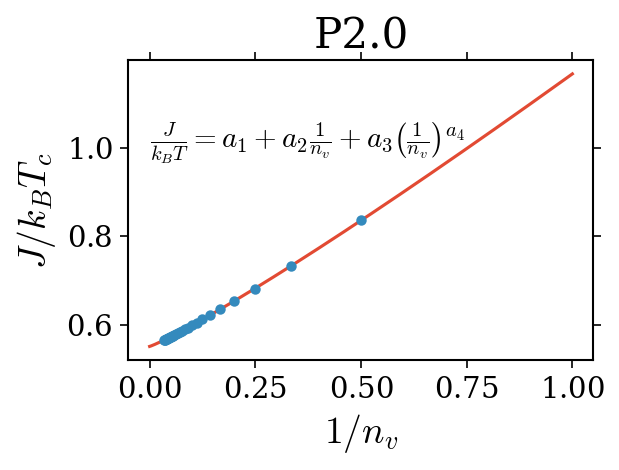

a1: 0.5510013515230202
a3: 0.6155145870013753
a4: 1.1136982619093714
Extrapolation:
0.5510013515230202 at 1/nv=0
1.1665159385243955 at 1/nv=1
min:0.5510013515230202 at 0.0




In [45]:
COLUMNS = ["P1.0","P1.05","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
path_save_graph = Path("../../graphs/h-1").resolve()
# file_name_base = 'inv_Tc_vs_inv_nv_extrapol_linear_and_power_law_3_parms'
file_name_base = 'inv_Tc_vs_inv_nv_extrapol_and_power_law_3_parms'
for COLUMN in COLUMNS:
    file_graph = file_name_base + '_{}.png'.format(COLUMN)
    # Get the data in arrays
    df_part = df_all_tc[["1/nv",COLUMN]]
    df_part = df_part.dropna()
    x_data = df_part['1/nv'].values
    y_data = df_part[COLUMN].values
#     # add value at nv=1
#     x_data = np.concatenate([x_data,[1]])
#     y_data = np.concatenate([y_data,[1.19968]])
    if COLUMN == 'P1.0':
        #add value at nv=infty
        x_data = np.insert(x_data,0,0)
        y_data = np.insert(y_data,0,0)

#     # for square
#     y_data = y_data**2    

    # fit 
#     (a1,a2,a3,a4), _= curve_fit(f=model_function,xdata=x_data,ydata=y_data,maxfev=10000,p0=[1, 1, 1, 0.5],
#                                bounds=([0, 0, 0, 0], [1, inf, inf, 5])
#                                )
#     df_params[COLUMN] = [a1,a2,a3,a4]
#     extrapol_funct = get_extrapol_function(model_function, a1, a2, a3,a4)
    (a1,a3,a4), _= curve_fit(f=model_function,xdata=x_data,ydata=y_data,maxfev=10000,p0=[1, 1, 0.5],
                               bounds=([0, 0, 0], [1, inf, 5])
                               )
    df_params[COLUMN] = [a1,a3,a4]
    extrapol_funct = get_extrapol_function(model_function, a1, a3,a4)

    
    # define the point for graph
    x_extrapol = np.linspace(0, 1, 2048)
    y_extrapol = extrapol_funct(x_extrapol)

    # Load the default style.
    style.use("default")
    rcParams["text.usetex"] = False

    fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
    grid_spec = GridSpec(3, 1)

    # Specific heat subplot.
    ax: Axes = fig1.add_subplot(grid_spec[0, 0])

    ax.plot(x_extrapol, y_extrapol, lw=1.5)
    ax.plot(x_data, y_data, marker="o", lw=0)

    ax.set_xlabel(r"$1/n_v$")
    ax.set_ylabel(r"$J/k_BT_c$")
    # add text
    ax.text(0, 1, r"$\frac{J}{k_BT} = a_1 + a_2 \frac{1}{n_v} + a_3 \left(\frac{1}{n_v}\right)^{a_4}$")

    ax.set_title(COLUMN)
    pyplot.draw()
#     print('Save graph {}'.format(os.path.join(path_save_graph,file_graph)))
#     pyplot.savefig(os.path.join(path_save_graph,file_graph))
    pyplot.show()
#     print("a1: {}\na2: {}\na3: {}\na4: {}".format(a1,a2,a3,a4))
    print("a1: {}\na3: {}\na4: {}".format(a1,a3,a4))
    print("Extrapolation:\n{} at 1/nv=0\n{} at 1/nv=1".format(extrapol_funct(0),extrapol_funct(1)))
    df_extrapol_val[COLUMN] = [extrapol_funct(0),extrapol_funct(1)]  
    print("min:{} at {}".format(np.nanmin(y_extrapol),x_extrapol[np.nanargmin(y_extrapol)]))    
    print("\n")


In [11]:
0.0001**0.06595614116937931

0.5447226517117655

## Save params

In [42]:
print(data_path)
file_name_base

C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\regular\infinite-size


'inv_Tc_vs_inv_nv_extrapol_and_power_law_3_parms'

In [46]:
# Define tha path and name for the csv files
file_params = os.path.join(data_path,'Extrapolation',file_name_base+'_params_curves.csv')
file_extrapol_values = os.path.join(data_path,'Extrapolation',file_name_base+'_extrapol_values.csv')
print(df_params)
print("Exporting to csv files the params adjusted {}".format(file_params))
df_params.to_csv(file_params)
print(df_extrapol_val)
print("Exporting to csv files the extrapolation values adjusted {}".format(file_extrapol_values))
df_extrapol_val.to_csv(file_extrapol_values)

        P1.0     P1.05      P1.1      P1.2      P1.3      P1.4      P1.5  \
a1  0.016979  0.114034  0.129638  0.164866  0.201064  0.242382  0.288786   
a3  0.912126  0.936814  0.923100  0.893469  0.861799  0.824652  0.784026   
a4  0.556473  0.758031  0.754238  0.754623  0.750620  0.755024  0.771474   

        P1.6      P1.7      P1.8      P1.9      P2.0  
a1  0.340433  0.392965  0.446996  0.500436  0.551001  
a3  0.747412  0.706956  0.670741  0.642875  0.615515  
a4  0.810023  0.855010  0.921669  1.012117  1.113698  
Exporting to csv files the params adjusted C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\regular\infinite-size\Extrapolation\inv_Tc_vs_inv_nv_extrapol_and_power_law_3_parms_params_curves.csv
           P1.0     P1.05      P1.1      P1.2      P1.3      P1.4      P1.5  \
infty  0.016979  0.114034  0.129638  0.164866  0.201064  0.242382  0.288786   
1      0.929105  1.050849  1.052737  1.058336  1.062863  1.067035  1.072812   

           P1.6   

## Plot extrapol values

Save graph C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\graphs\h-1\Extrapolation\inv_Tc_vs_inv_nv_extrapol_linear_and_power_law_4_parms_all_p.png


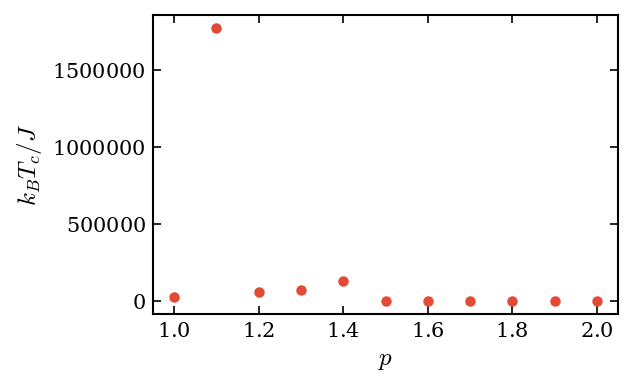

In [17]:
file_extrapol_graph = os.path.join(path_save_graph,'Extrapolation',file_name_base+'_all_p.png')
# data 
x_data = np.arange(1,2.1,0.1)
y_data = 1/df_extrapol_val.loc['infty'].values

# data for squared 
y_data = np.sqrt(y_data)

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(x_data, y_data, marker="o", lw=0)

ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$k_BT_c/J$")

pyplot.draw()

print('Save graph {}'.format(file_extrapol_graph))
pyplot.savefig(file_extrapol_graph)

pyplot.show()